In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

Time series problem
1. Purely random error
2. Curvilinear Trend (quadratic, exponential)
3. Increasing linear trend
4. Seasonal pattern
5. Seasonal pattern plus linear growth


In [85]:
df = pd.read_csv('AEP_hourly.csv')

In [86]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [87]:
df.tail()


,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [88]:
df = df.set_index('Datetime')

In [89]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


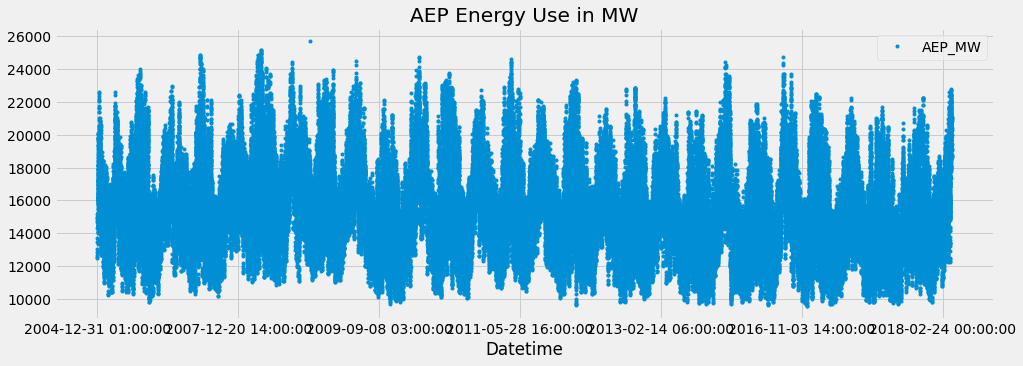

In [90]:
df.plot(style='.', figsize=(15,5), color = color_pal[0], title='AEP Energy Use in MW' )
plt.show()

In [91]:
df.index

Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121273)

In [92]:
df.index = pd.to_datetime(df.index)

In [93]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

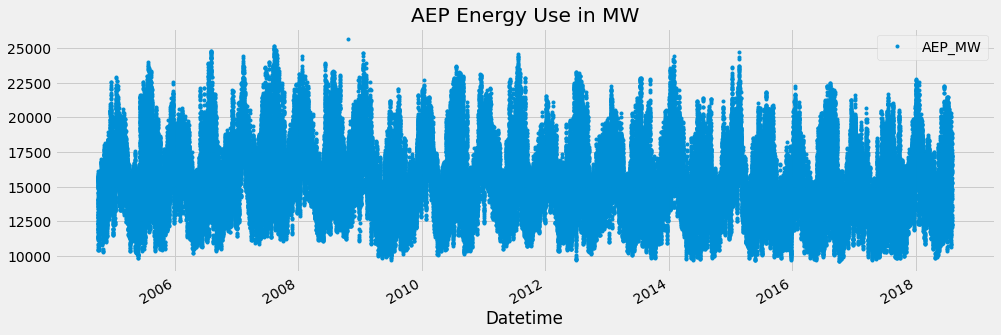

In [94]:
df.plot(style='.', figsize=(15,5), color = color_pal[0], title='AEP Energy Use in MW' )
plt.show()

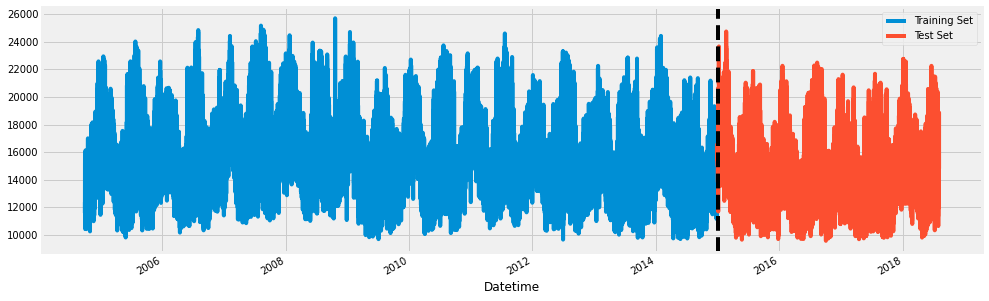

In [13]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

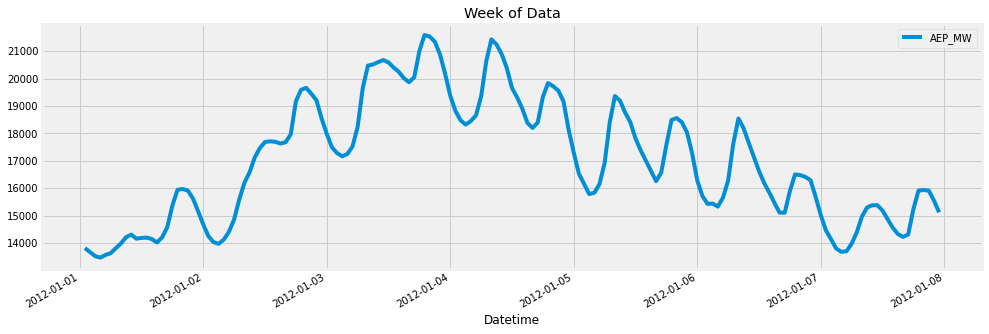

In [14]:
df.loc[(df.index > '01-01-2012') & (df.index < '01-08-2012')].plot(figsize=(15,5), title='Week of Data')
plt.show()

Feature Creation

In [16]:

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear


In [17]:
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1


Visualize the feature/ target relationship

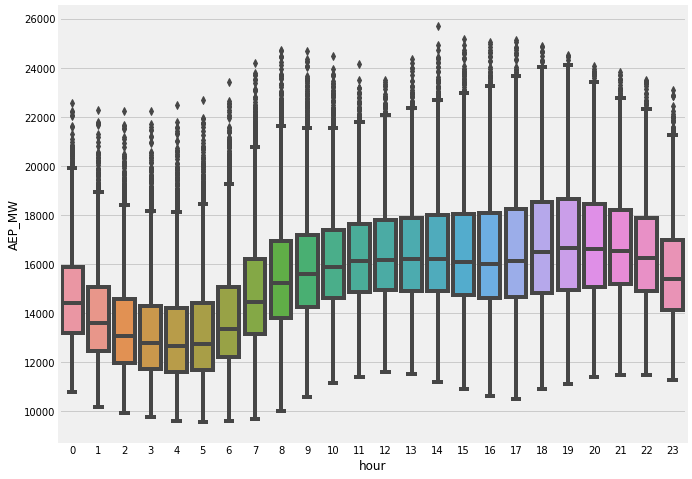

In [18]:
fig. ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by hour')
plt.show()

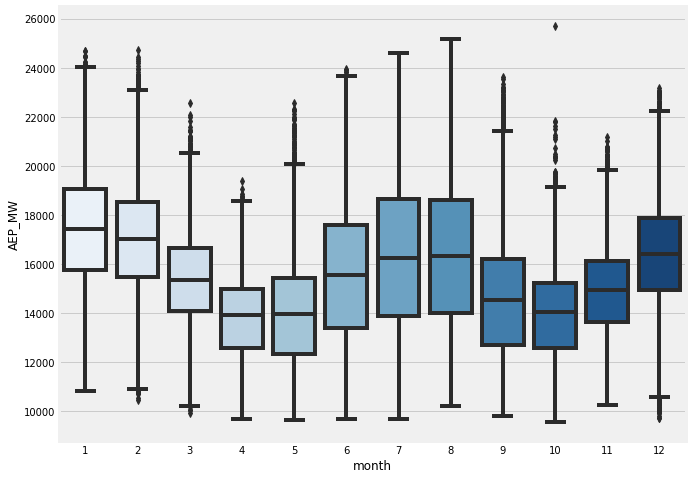

In [19]:
fig. ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

Create Model

In [20]:
train = df.loc[df.index < '01-01-2014']
test = df.loc[df.index >= '01-01-2014']

In [21]:
train.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2013-01-01 15:00:00', '2013-01-01 16:00:00',
               '2013-01-01 17:00:00', '2013-01-01 18:00:00',
               '2013-01-01 19:00:00', '2013-01-01 20:00:00',
               '2013-01-01 21:00:00', '2013-01-01 22:00:00',
               '2013-01-01 23:00:00', '2013-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=81074, freq=None)

In [22]:
test.index

DatetimeIndex(['2014-01-01 00:00:00', '2014-12-31 01:00:00',
               '2014-12-31 02:00:00', '2014-12-31 03:00:00',
               '2014-12-31 04:00:00', '2014-12-31 05:00:00',
               '2014-12-31 06:00:00', '2014-12-31 07:00:00',
               '2014-12-31 08:00:00', '2014-12-31 09:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=40199, freq=None)

In [23]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [24]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [25]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [27]:
reg = xgb.XGBRegressor(n_estimators=5000,early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15994.14169	validation_1-rmse:15084.19307
[100]	validation_0-rmse:14486.98006	validation_1-rmse:13593.16526
[200]	validation_0-rmse:13124.62394	validation_1-rmse:12246.71140
[300]	validation_0-rmse:11893.28974	validation_1-rmse:11026.68595
[400]	validation_0-rmse:10780.77018	validation_1-rmse:9925.26570
[500]	validation_0-rmse:9775.77364	validation_1-rmse:8933.99771
[600]	validation_0-rmse:8868.34575	validation_1-rmse:8047.18111
[700]	validation_0-rmse:8049.15549	validation_1-rmse:7248.35753
[800]	validation_0-rmse:7309.58345	validation_1-rmse:6532.76438
[900]	validation_0-rmse:6642.44947	validation_1-rmse:5887.86803
[1000]	validation_0-rmse:6040.94571	validation_1-rmse:5313.36659
[1100]	validation_0-rmse:5499.09002	validation_1-rmse:4797.19168
[1200]	validation_0-rmse:5011.54679	validation_1-rmse:4336.72077
[1300]	validation_0-rmse:4572.88244	validation_1-rmse:3929.73285
[1400]	validation_0-rmse:4178.57052	validation_1-rmse:3569.68698
[1500]	validation_0-rmse:382

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Feature Importances

In [28]:
fi = pd.DataFrame(data=reg.feature_importances_, 
             index=reg.feature_names_in_, 
             columns=['importance']).sort_values('importance')


In [29]:
fi

,importance
quarter,0.014026
year,0.043176
dayofyear,0.128953
month,0.192042
dayofweek,0.194698
hour,0.427105


<Axes: title={'center': 'Feature Importance'}>

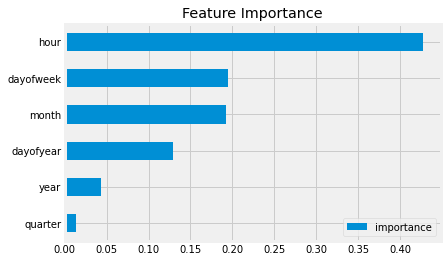

In [30]:
fi.plot(kind='barh', title='Feature Importance')

Forecast on Test

In [44]:
test['prediction'] = reg.predict(X_test)


In [45]:
test

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2014-01-01 00:00:00,15922.0,0,2,1,1,2014,1,14751.780273
2014-12-31 01:00:00,15993.0,1,2,4,12,2014,365,14409.588867
2014-12-31 02:00:00,15780.0,2,2,4,12,2014,365,14202.623047
2014-12-31 03:00:00,15769.0,3,2,4,12,2014,365,14142.222656
2014-12-31 04:00:00,15738.0,4,2,4,12,2014,365,14142.222656
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,17231.175781
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,17231.175781
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,17219.843750


In [49]:
df = df.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)

In [50]:
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18208.529297
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18208.529297
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,18086.013672


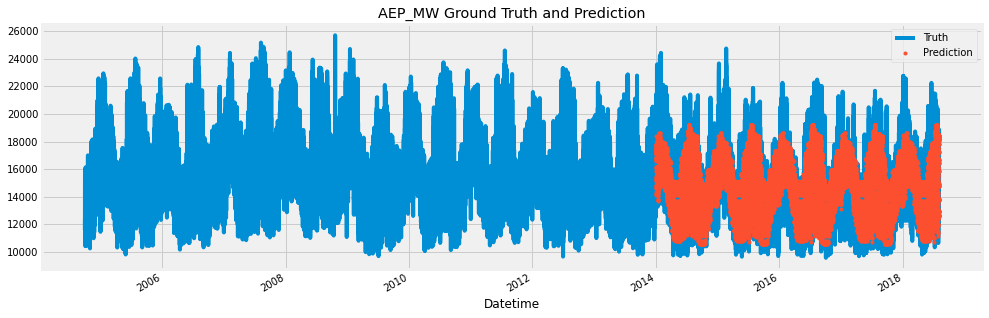

In [52]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth', 'Prediction'])
ax.set_title('AEP_MW Ground Truth and Prediction')
plt.show()

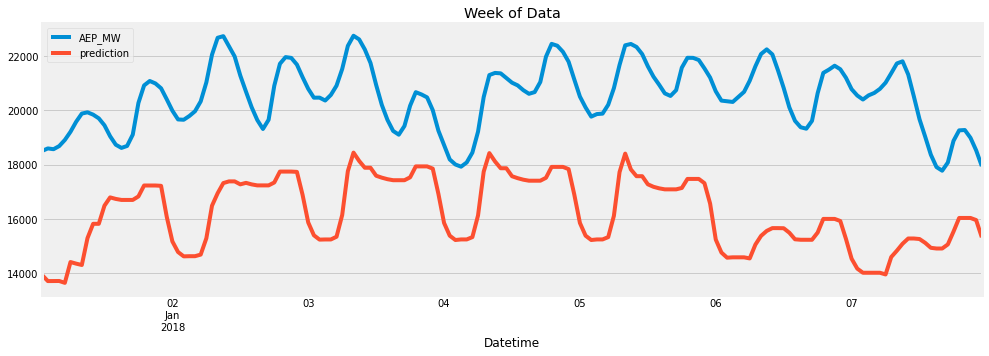

In [57]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018'),['AEP_MW', 'prediction']].plot(figsize=(15,5), title='Week of Data')
plt.show()

In [61]:
RMSE = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE on test set: {RMSE:0.2f}')

RMSE on test set: 1527.72


In [62]:
test['Error'] = np.abs(test[TARGET] - test['prediction'])
test['Date'] = test.index.date

In [64]:
test.groupby('Date')['Error'].mean().sort_values(ascending=False).head()

Date
2015-02-20    5700.016276
2015-02-19    5675.574951
2018-01-06    5561.649211
2014-01-07    5390.142863
2014-01-28    5241.820028
Name: Error, dtype: float64

Next steps

More cross validation
more features (weather forecast, holidays)

Outliers Analysis and removel

In [65]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


<Axes: ylabel='Frequency'>

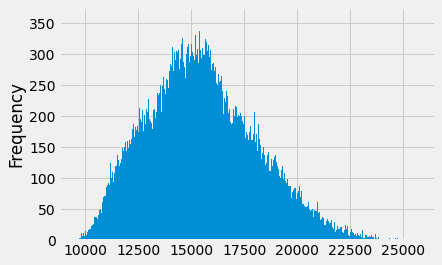

In [66]:
df['AEP_MW'].plot(kind='hist', bins=1000)

<Axes: xlabel='Datetime'>

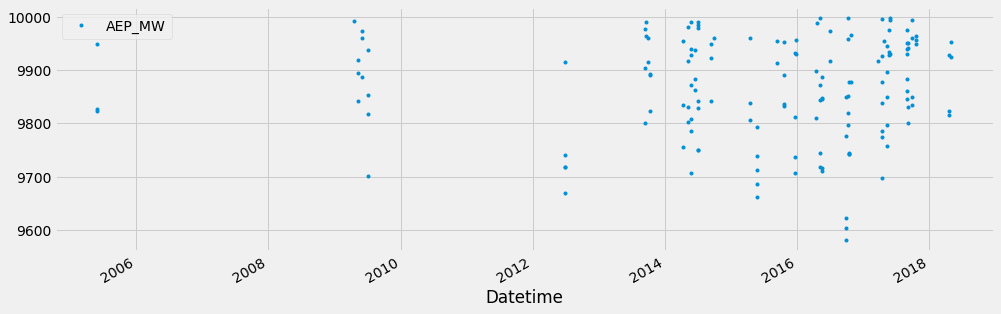

In [67]:
df.query('AEP_MW < 10000').plot(figsize=(15,5), style = '.')

Time Series Cross validation

In [68]:
from sklearn.model_selection import TimeSeriesSplit

In [69]:
tss = TimeSeriesSplit(n_splits=5, test_size= 24*365, gap=24) 
df = df.sort_index()

In [70]:
for train_idx, val_idx in tss.split(df):
    break

In [71]:
train_idx

array([    0,     1,     2, ..., 77446, 77447, 77448])

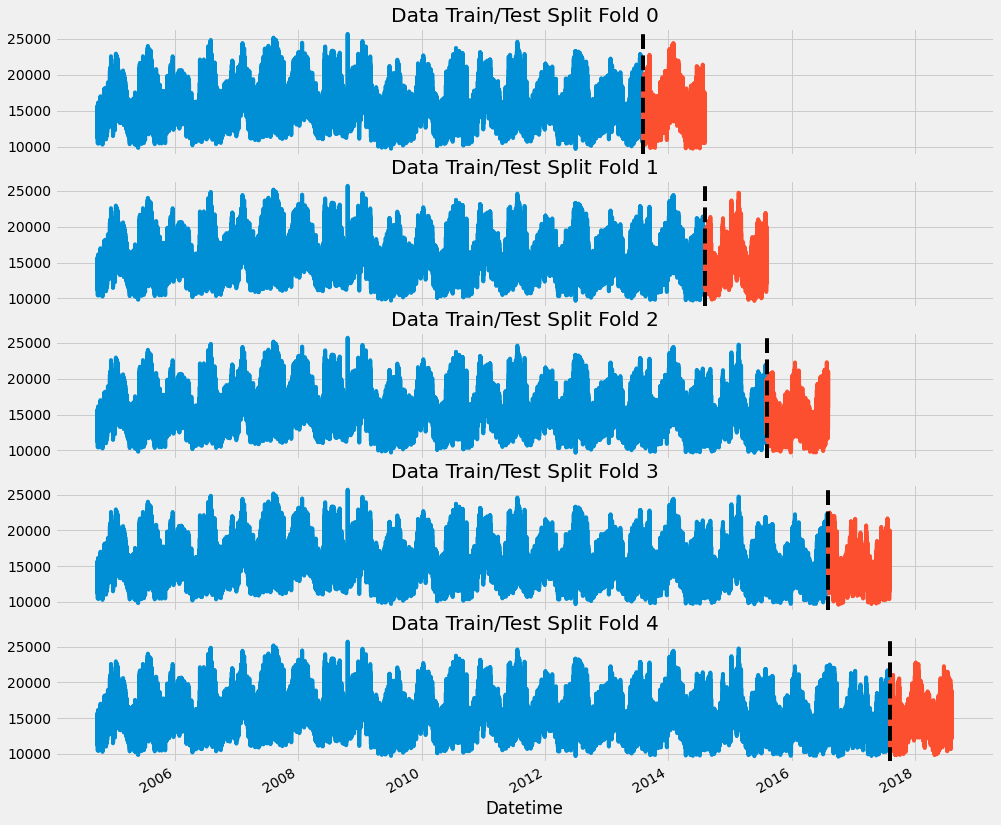

In [72]:
fig, axs =plt.subplots(nrows=5, ncols=1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

In [104]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

In [106]:
df = create_features(df)
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,40,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,40,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,40,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,40,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,40,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,31,18705.0,20140.0,16078.0
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,31,18108.0,19616.0,15908.0
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,31,17544.0,19246.0,15783.0


Lag features

In [97]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1']=(df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2']=(df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3']=(df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [98]:
df = add_lags(df)

In [99]:
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,53,NaN,NaN,NaN
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,53,NaN,NaN,NaN
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,53,NaN,NaN,NaN
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,53,NaN,NaN,NaN
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,53,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,14832.0,18928.0,20189.0
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,14621.0,18789.0,19953.0
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,14153.0,18402.0,19329.0


Train using cross validation

In [107]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'weekofyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [109]:
tss=TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap =24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'weekofyear', 'lag1', 'lag2', 'lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[18:57:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15898.36248	validation_1-rmse:15264.17093


<ipython-input-104-29628b9ec07c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-104-29628b9ec07c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-104-29628b9ec07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[100]	validation_0-rmse:6030.95990	validation_1-rmse:5645.44120
[200]	validation_0-rmse:2654.40671	validation_1-rmse:2433.18696
[300]	validation_0-rmse:1707.80849	validation_1-rmse:1644.04104
[400]	validation_0-rmse:1488.42945	validation_1-rmse:1550.21684
[469]	validation_0-rmse:1440.58922	validation_1-rmse:1555.17598
[18:57:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15835.43826	validation_1-rmse:15221.94439


<ipython-input-104-29628b9ec07c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-104-29628b9ec07c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-104-29628b9ec07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[100]	validation_0-rmse:6007.64792	validation_1-rmse:5714.96333
[200]	validation_0-rmse:2645.13340	validation_1-rmse:2506.50760
[300]	validation_0-rmse:1707.82903	validation_1-rmse:1617.73379
[400]	validation_0-rmse:1500.97926	validation_1-rmse:1452.11844
[500]	validation_0-rmse:1442.07588	validation_1-rmse:1427.39253
[600]	validation_0-rmse:1409.82623	validation_1-rmse:1423.22243
[649]	validation_0-rmse:1398.77842	validation_1-rmse:1423.86060
[18:57:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15779.22927	validation_1-rmse:14549.83302


<ipython-input-104-29628b9ec07c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-104-29628b9ec07c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-104-29628b9ec07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[100]	validation_0-rmse:5985.40641	validation_1-rmse:5100.58721
[200]	validation_0-rmse:2635.28786	validation_1-rmse:2052.99873
[300]	validation_0-rmse:1704.43235	validation_1-rmse:1509.27665
[370]	validation_0-rmse:1533.89307	validation_1-rmse:1519.07143
[18:57:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15679.42399	validation_1-rmse:14632.70104


<ipython-input-104-29628b9ec07c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-104-29628b9ec07c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-104-29628b9ec07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[100]	validation_0-rmse:5950.43942	validation_1-rmse:5462.00230
[200]	validation_0-rmse:2627.57480	validation_1-rmse:2467.71518
[300]	validation_0-rmse:1706.76013	validation_1-rmse:1775.90081
[400]	validation_0-rmse:1504.15781	validation_1-rmse:1666.96890
[500]	validation_0-rmse:1449.00479	validation_1-rmse:1657.85188
[524]	validation_0-rmse:1440.13992	validation_1-rmse:1657.08094
[18:58:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15600.77061	validation_1-rmse:15012.56020


<ipython-input-104-29628b9ec07c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-104-29628b9ec07c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-104-29628b9ec07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[100]	validation_0-rmse:5924.76345	validation_1-rmse:5857.29066
[200]	validation_0-rmse:2626.20056	validation_1-rmse:2769.32063
[300]	validation_0-rmse:1717.78653	validation_1-rmse:1895.15939
[400]	validation_0-rmse:1514.35918	validation_1-rmse:1709.15899
[500]	validation_0-rmse:1456.52184	validation_1-rmse:1695.48098
[514]	validation_0-rmse:1451.80813	validation_1-rmse:1696.72830


In [111]:
print(f'Score across folds {np.mean(score):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1690.5092
Fold scores:[1549.028322936375, 1422.5566107454813, 1499.498707473989, 1656.4476574414657, 1690.5092105134202]


Predicting the Future

1 Retrain on all data
2 Predict the future we need an empty dataframe for future data range
3 Run those dates through our feature creation code + lag creation

In [112]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'weekofyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [115]:
# Retrain on all data
df = create_features(df)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'weekofyear', 'lag1', 'lag2', 'lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[19:08:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15559.01125
[100]	validation_0-rmse:5908.62547
[200]	validation_0-rmse:2621.91536
[300]	validation_0-rmse:1721.21816
[400]	validation_0-rmse:1523.00040
[499]	validation_0-rmse:1471.22405


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [116]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [118]:
# Create future dataframe
pd.date_range('2018-08-03', '2019-08-01', freq='1h')


DatetimeIndex(['2018-08-03 00:00:00', '2018-08-03 01:00:00',
               '2018-08-03 02:00:00', '2018-08-03 03:00:00',
               '2018-08-03 04:00:00', '2018-08-03 05:00:00',
               '2018-08-03 06:00:00', '2018-08-03 07:00:00',
               '2018-08-03 08:00:00', '2018-08-03 09:00:00',
               ...
               '2019-07-31 15:00:00', '2019-07-31 16:00:00',
               '2019-07-31 17:00:00', '2019-07-31 18:00:00',
               '2019-07-31 19:00:00', '2019-07-31 20:00:00',
               '2019-07-31 21:00:00', '2019-07-31 22:00:00',
               '2019-07-31 23:00:00', '2019-08-01 00:00:00'],
              dtype='datetime64[ns]', length=8713, freq='H')

In [119]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [120]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [121]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,31,15045.0,16491.0,13669.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,31,13940.0,15319.0,12772.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,31,13230.0,14492.0,12253.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,31,12624.0,13945.0,11928.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,31,12410.0,13619.0,11696.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,16579.0,18495.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,16457.0,17771.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,16197.0,17220.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,15259.0,16100.0,17790.0,True


Predict the future

In [123]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

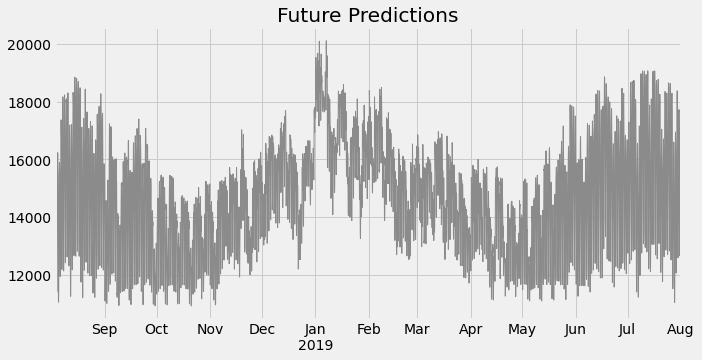

In [127]:
future_w_features['pred'].plot(figsize=(10,5), color=color_pal[4], ms=1, lw=1, title='Future Predictions')
plt.show()

Saving model for later

In [129]:
reg.save_model('model.json')

In [130]:
!ls -lh

total 46896
-rw-rw-r--@  1 chris  staff   3.2M Oct  4  2019 AEP_hourly.csv
-rw-r--r--@  1 chris  staff   610K Apr 23 08:16 AEP_hourly.csv.zip
-rw-r--r--@  1 chris  staff   840K Apr 23 18:34 Time_Series_Forcasting_AEP.ipynb
drwx------@ 19 chris  staff   608B Apr 23 06:33 archive
-rw-r--r--@  1 chris  staff    18M Apr 23 06:33 archive.zip
-rw-r--r--@  1 chris  staff   569K Apr 23 19:41 model.json


In [131]:
# load the model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

<Axes: title={'center': 'Future Preductions'}>

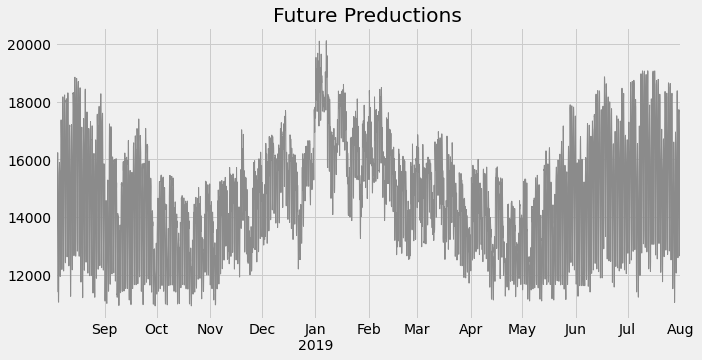

In [132]:
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10,5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Preductions')